In [ ]:
pip install seaborn pandas matplotlib scipy scikit_posthocs

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
import scikit_posthocs as sp
from scipy.stats import kruskal
from statsmodels.stats.multitest import multipletests
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp

exp_json = "./experiment-20260218.json"

methods = ["bruteforce", "dfs", "hillclimb", "buildingwalk"]

df = pd.read_json(exp_json)
df.to_pickle("experiment.pickle")
df.to_csv("experiment-20260218.csv")
#print("Experiment:")
#print(df)

In [8]:
#p < 0.05 → At least one method is statistically different.
#p ≥ 0.05 → No significant difference detected.
# 69845e0e-2cc8-832d-8bfe-9614d7f18f5c
groups = [
    df[df["method"] == "bruteforce"]["best_score"],
    df[df["method"] == "buildingwalk"]["best_score"],
    df[df["method"] == "dfs"]["best_score"],
    df[df["method"] == "hillclimb"]["best_score"],
]

stat, p = kruskal(*groups)

print("Kruskal-Wallis H:", stat)
print("p-value:", p)

Kruskal-Wallis H: 50.854635362435104
p-value: 5.253669760512343e-11


In [2]:
for radius in sorted(df["radius"].unique()):
    subset = df[df["radius"] == radius]
    
    groups = [
        subset[subset["method"] == m]["best_score"]
        for m in subset["method"].unique()
    ]
    
    stat, p = kruskal(*groups)
    print(f"Radius {radius}: H={stat:.3f}, p={p:.4f}")

Radius 50: H=15.943, p=0.0012
Radius 100: H=9.792, p=0.0204
Radius 150: H=20.441, p=0.0001
Radius 200: H=46.246, p=0.0000


In [3]:
# Dunns test (post-hoc)
sp.posthoc_dunn(
    df,
    val_col="best_score",
    group_col="method",
    p_adjust="bonferroni"
)

,bruteforce,buildingwalk,dfs,hillclimb
bruteforce,1.000000e+00,0.000004,0.000898,2.998012e-11
buildingwalk,3.753930e-06,1.000000,1.000000,3.272230e-01
dfs,8.976311e-04,1.000000,1.000000,1.107618e-02
hillclimb,2.998012e-11,0.327223,0.011076,1.000000e+00


In [7]:
results = []

for radius in sorted(df["radius"].unique()):
    for activation in df["activation_function"].unique():
        
        # Subset for this condition
        subset = df[
            (df["radius"] == radius) &
            (df["activation_function"] == activation)
        ]
        
        # Get groups per method
        methods = subset["method"].unique()
        groups = [
            subset[subset["method"] == m]["best_score"]
            for m in methods
        ]
        
        # Only test if at least 2 groups exist and have data
        if len(groups) > 1 and all(len(g) > 0 for g in groups):
            stat, p = kruskal(*groups)
            
            results.append({
                "radius": radius,
                "activation_function": activation,
                "H_statistic": stat,
                "p_value": p
            })

# Convert to DataFrame
results_df = pd.DataFrame(results)
results_df["p_corrected"] = multipletests(
    results_df["p_value"],
    method="bonferroni"
)[1]
print(results_df)

    radius activation_function  H_statistic   p_value  p_corrected
0       50             sigmoid     4.225546  0.238117     1.000000
1       50              linear     5.988068  0.112192     1.000000
2       50             uniform    10.104727  0.017697     0.212359
3      100             sigmoid     1.994827  0.573481     1.000000
4      100              linear     3.626333  0.304743     1.000000
5      100             uniform     7.548634  0.056322     0.675863
6      150             sigmoid     3.434003  0.329423     1.000000
7      150              linear     5.063986  0.167171     1.000000
8      150             uniform    20.421374  0.000139     0.001666
9      200             sigmoid    10.740596  0.013215     0.158575
10     200              linear    11.882747  0.007796     0.093550
11     200             uniform    29.747070  0.000002     0.000019


In [8]:
print(results_df.to_latex(multirow=True, escape=False))

\begin{tabular}{lrlrrr}
\toprule
 & radius & activation_function & H_statistic & p_value & p_corrected \\
\midrule
0 & 50 & sigmoid & 4.225546 & 0.238117 & 1.000000 \\
1 & 50 & linear & 5.988068 & 0.112192 & 1.000000 \\
2 & 50 & uniform & 10.104727 & 0.017697 & 0.212359 \\
3 & 100 & sigmoid & 1.994827 & 0.573481 & 1.000000 \\
4 & 100 & linear & 3.626333 & 0.304743 & 1.000000 \\
5 & 100 & uniform & 7.548634 & 0.056322 & 0.675863 \\
6 & 150 & sigmoid & 3.434003 & 0.329423 & 1.000000 \\
7 & 150 & linear & 5.063986 & 0.167171 & 1.000000 \\
8 & 150 & uniform & 20.421374 & 0.000139 & 0.001666 \\
9 & 200 & sigmoid & 10.740596 & 0.013215 & 0.158575 \\
10 & 200 & linear & 11.882747 & 0.007796 & 0.093550 \\
11 & 200 & uniform & 29.747070 & 0.000002 & 0.000019 \\
\bottomrule
\end{tabular}



In [9]:
results = []

for activation in df["activation_function"].unique():
    for method in df["method"].unique():
        
        subset = df[
            (df["activation_function"] == activation) &
            (df["method"] == method)
        ]
        
        radii = sorted(subset["radius"].unique())
        
        groups = [
            subset[subset["radius"] == r]["best_score"]
            for r in radii
        ]
        
        if len(groups) > 1 and all(len(g) > 0 for g in groups):
            stat, p = kruskal(*groups)
            
            results.append({
                "activation_function": activation,
                "method": method,
                "H_statistic": stat,
                "p_value": p
            })

results_df = pd.DataFrame(results)

# Multiple comparison correction (12 tests)
results_df["p_corrected"] = multipletests(
    results_df["p_value"],
    method="holm"   # better than bonferroni
)[1]

print(results_df)

   activation_function        method  H_statistic       p_value   p_corrected
0              sigmoid    bruteforce   385.592869  2.922126e-83  2.922126e-82
1              sigmoid     hillclimb   326.069235  2.264050e-70  1.132025e-69
2              sigmoid  buildingwalk   401.204497  1.214093e-86  1.335502e-85
3              sigmoid           dfs   348.354332  3.388519e-75  2.371964e-74
4               linear    bruteforce   370.586900  5.195524e-80  4.675972e-79
5               linear     hillclimb   299.971067  1.009324e-64  3.027973e-64
6               linear  buildingwalk   402.061881  7.916525e-87  9.499831e-86
7               linear           dfs   323.291043  9.043075e-70  3.617230e-69
8              uniform    bruteforce   332.749126  8.104817e-72  4.862890e-71
9              uniform     hillclimb   259.565973  5.580750e-56  5.580750e-56
10             uniform  buildingwalk   360.197078  9.238666e-78  7.390933e-77
11             uniform           dfs   289.544129  1.822136e-62 

In [11]:
results = []

for activation in df["activation_function"].unique():
    
    subset = df[df["activation_function"] == activation]
    
    # Pivot so rows = radius, columns = method
    pivot = subset.pivot_table(
        index="radius",
        columns="method",
        values="best_score",
        aggfunc="mean"
    )
    
    # Ensure no missing values
    pivot = pivot.dropna()
    
    if pivot.shape[1] > 1:
        stat, p = friedmanchisquare(
            *[pivot[col] for col in pivot.columns]
        )
        
        results.append({
            "activation_function": activation,
            "Friedman_stat": stat,
            "p_value": p
        })

results_df = pd.DataFrame(results)
print(results_df)

  activation_function  Friedman_stat   p_value
0             sigmoid            9.9  0.019436
1              linear            8.4  0.038429
2             uniform            9.9  0.019436


In [12]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [13]:
model = ols(
    'best_score ~ C(activation_function) * C(method) * C(radius)',
    data=df
).fit()

anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                                                  sum_sq       df           F  \
C(activation_function)                      9.408457e+05      2.0  180.211568   
C(method)                                   6.850832e+04      3.0    8.748152   
C(radius)                                   3.404319e+06      3.0  434.713611   
C(activation_function):C(method)            2.995243e+04      6.0    1.912384   
C(activation_function):C(radius)            8.841111e+04      6.0    5.644816   
C(method):C(radius)                         3.023754e+04      9.0    1.287058   
C(activation_function):C(method):C(radius)  7.494814e+03     18.0    0.159508   
Residual                                    3.746435e+07  14352.0         NaN   

                                                   PR(>F)  
C(activation_function)                       5.031505e-78  
C(method)                                    8.571716e-06  
C(radius)                                   2.438329e-270  
C(activation_function):C(metho

<Figure size 3840x2880 with 0 Axes>

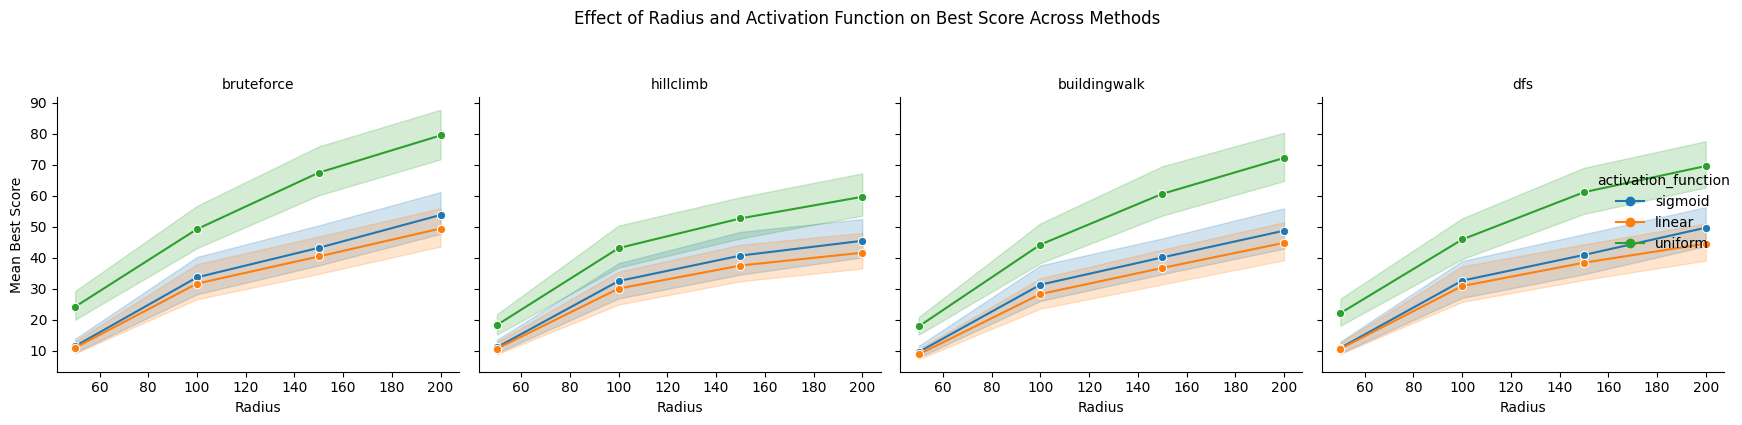

In [15]:
plt.figure(dpi=600)

g = sns.relplot(
    data=df,
    x="radius",
    y="best_score",
    hue="activation_function",
    col="method",
    kind="line",
    estimator="mean",
    marker="o",
    #errorbar="sd",   # remove if you want cleaner look
    height=4,
    aspect=1
)

g.set_axis_labels("Radius", "Mean Best Score")
g.set_titles("{col_name}")
g.fig.suptitle("Effect of Radius and Activation Function on Best Score Across Methods", y=1.05)

plt.tight_layout()
plt.savefig("anova_support_figure.png", dpi=600)
plt.show()

In [3]:
results = []

# Loop over activation functions
for activation in df["activation_function"].unique():
    df_activation = df[df["activation_function"] == activation]
    
    # Loop over radii
    for radius in sorted(df_activation["radius"].unique()):
        df_subset = df_activation[df_activation["radius"] == radius]
        
        # Prepare groups per method
        methods = df_subset["method"].unique()
        groups = [df_subset[df_subset["method"] == m]["best_score"].values for m in methods]
        
        # Only test if at least 2 methods exist and all have same number of repeated runs
        lengths = [len(g) for g in groups]
        if len(groups) > 1 and len(set(lengths)) == 1:
            stat, p = friedmanchisquare(*groups)
            
            results.append({
                "activation_function": activation,
                "radius": radius,
                "Friedman_statistic": stat,
                "p_value": p
            })

# Convert to DataFrame for easy inspection
friedman_results = pd.DataFrame(results)
print(friedman_results)

   activation_function  radius  Friedman_statistic        p_value
0              sigmoid      50          286.205443   9.617591e-62
1              sigmoid     100          460.796815   1.492373e-99
2              sigmoid     150          434.063539   9.247276e-94
3              sigmoid     200          396.745989   1.121992e-85
4               linear      50          270.556619   2.339065e-58
5               linear     100          499.039518  7.705853e-108
6               linear     150          429.472620   9.133159e-93
7               linear     200          400.922385   1.397526e-86
8              uniform      50          162.485588   5.329654e-35
9              uniform     100          281.367713   1.071248e-60
10             uniform     150          380.179918   4.345625e-82
11             uniform     200          434.405629   7.796513e-94


In [35]:
friedman_results["p_value_str"] = friedman_results["p_value"].map(lambda x: f"{x:.6e}")

# Make sure to use the string column in the LaTeX output
latex_table = friedman_results[["activation_function", "radius", "Friedman_statistic", "p_value_str"]].to_latex(
    index=False,
    escape=False
)

print(latex_table)

\begin{tabular}{lrrl}
\toprule
activation_function & radius & Friedman_statistic & p_value_str \\
\midrule
sigmoid & 50 & 286.205443 & 9.617591e-62 \\
sigmoid & 100 & 460.796815 & 1.492373e-99 \\
sigmoid & 150 & 434.063539 & 9.247276e-94 \\
sigmoid & 200 & 396.745989 & 1.121992e-85 \\
linear & 50 & 270.556619 & 2.339065e-58 \\
linear & 100 & 499.039518 & 7.705853e-108 \\
linear & 150 & 429.472620 & 9.133159e-93 \\
linear & 200 & 400.922385 & 1.397526e-86 \\
uniform & 50 & 162.485588 & 5.329654e-35 \\
uniform & 100 & 281.367713 & 1.071248e-60 \\
uniform & 150 & 380.179918 & 4.345625e-82 \\
uniform & 200 & 434.405629 & 7.796513e-94 \\
\bottomrule
\end{tabular}



In [6]:
friedman_results["radius"] = friedman_results["radius"].astype(int)
##friedman_results["best_score"] = friedman_results["best_score"].astype(float)
friedman_results["dist_weight"] = friedman_results["dist_weight"].astype(float)
sp.posthoc_nemenyi_friedman(friedman_results)

KeyError: 'dist_weight'

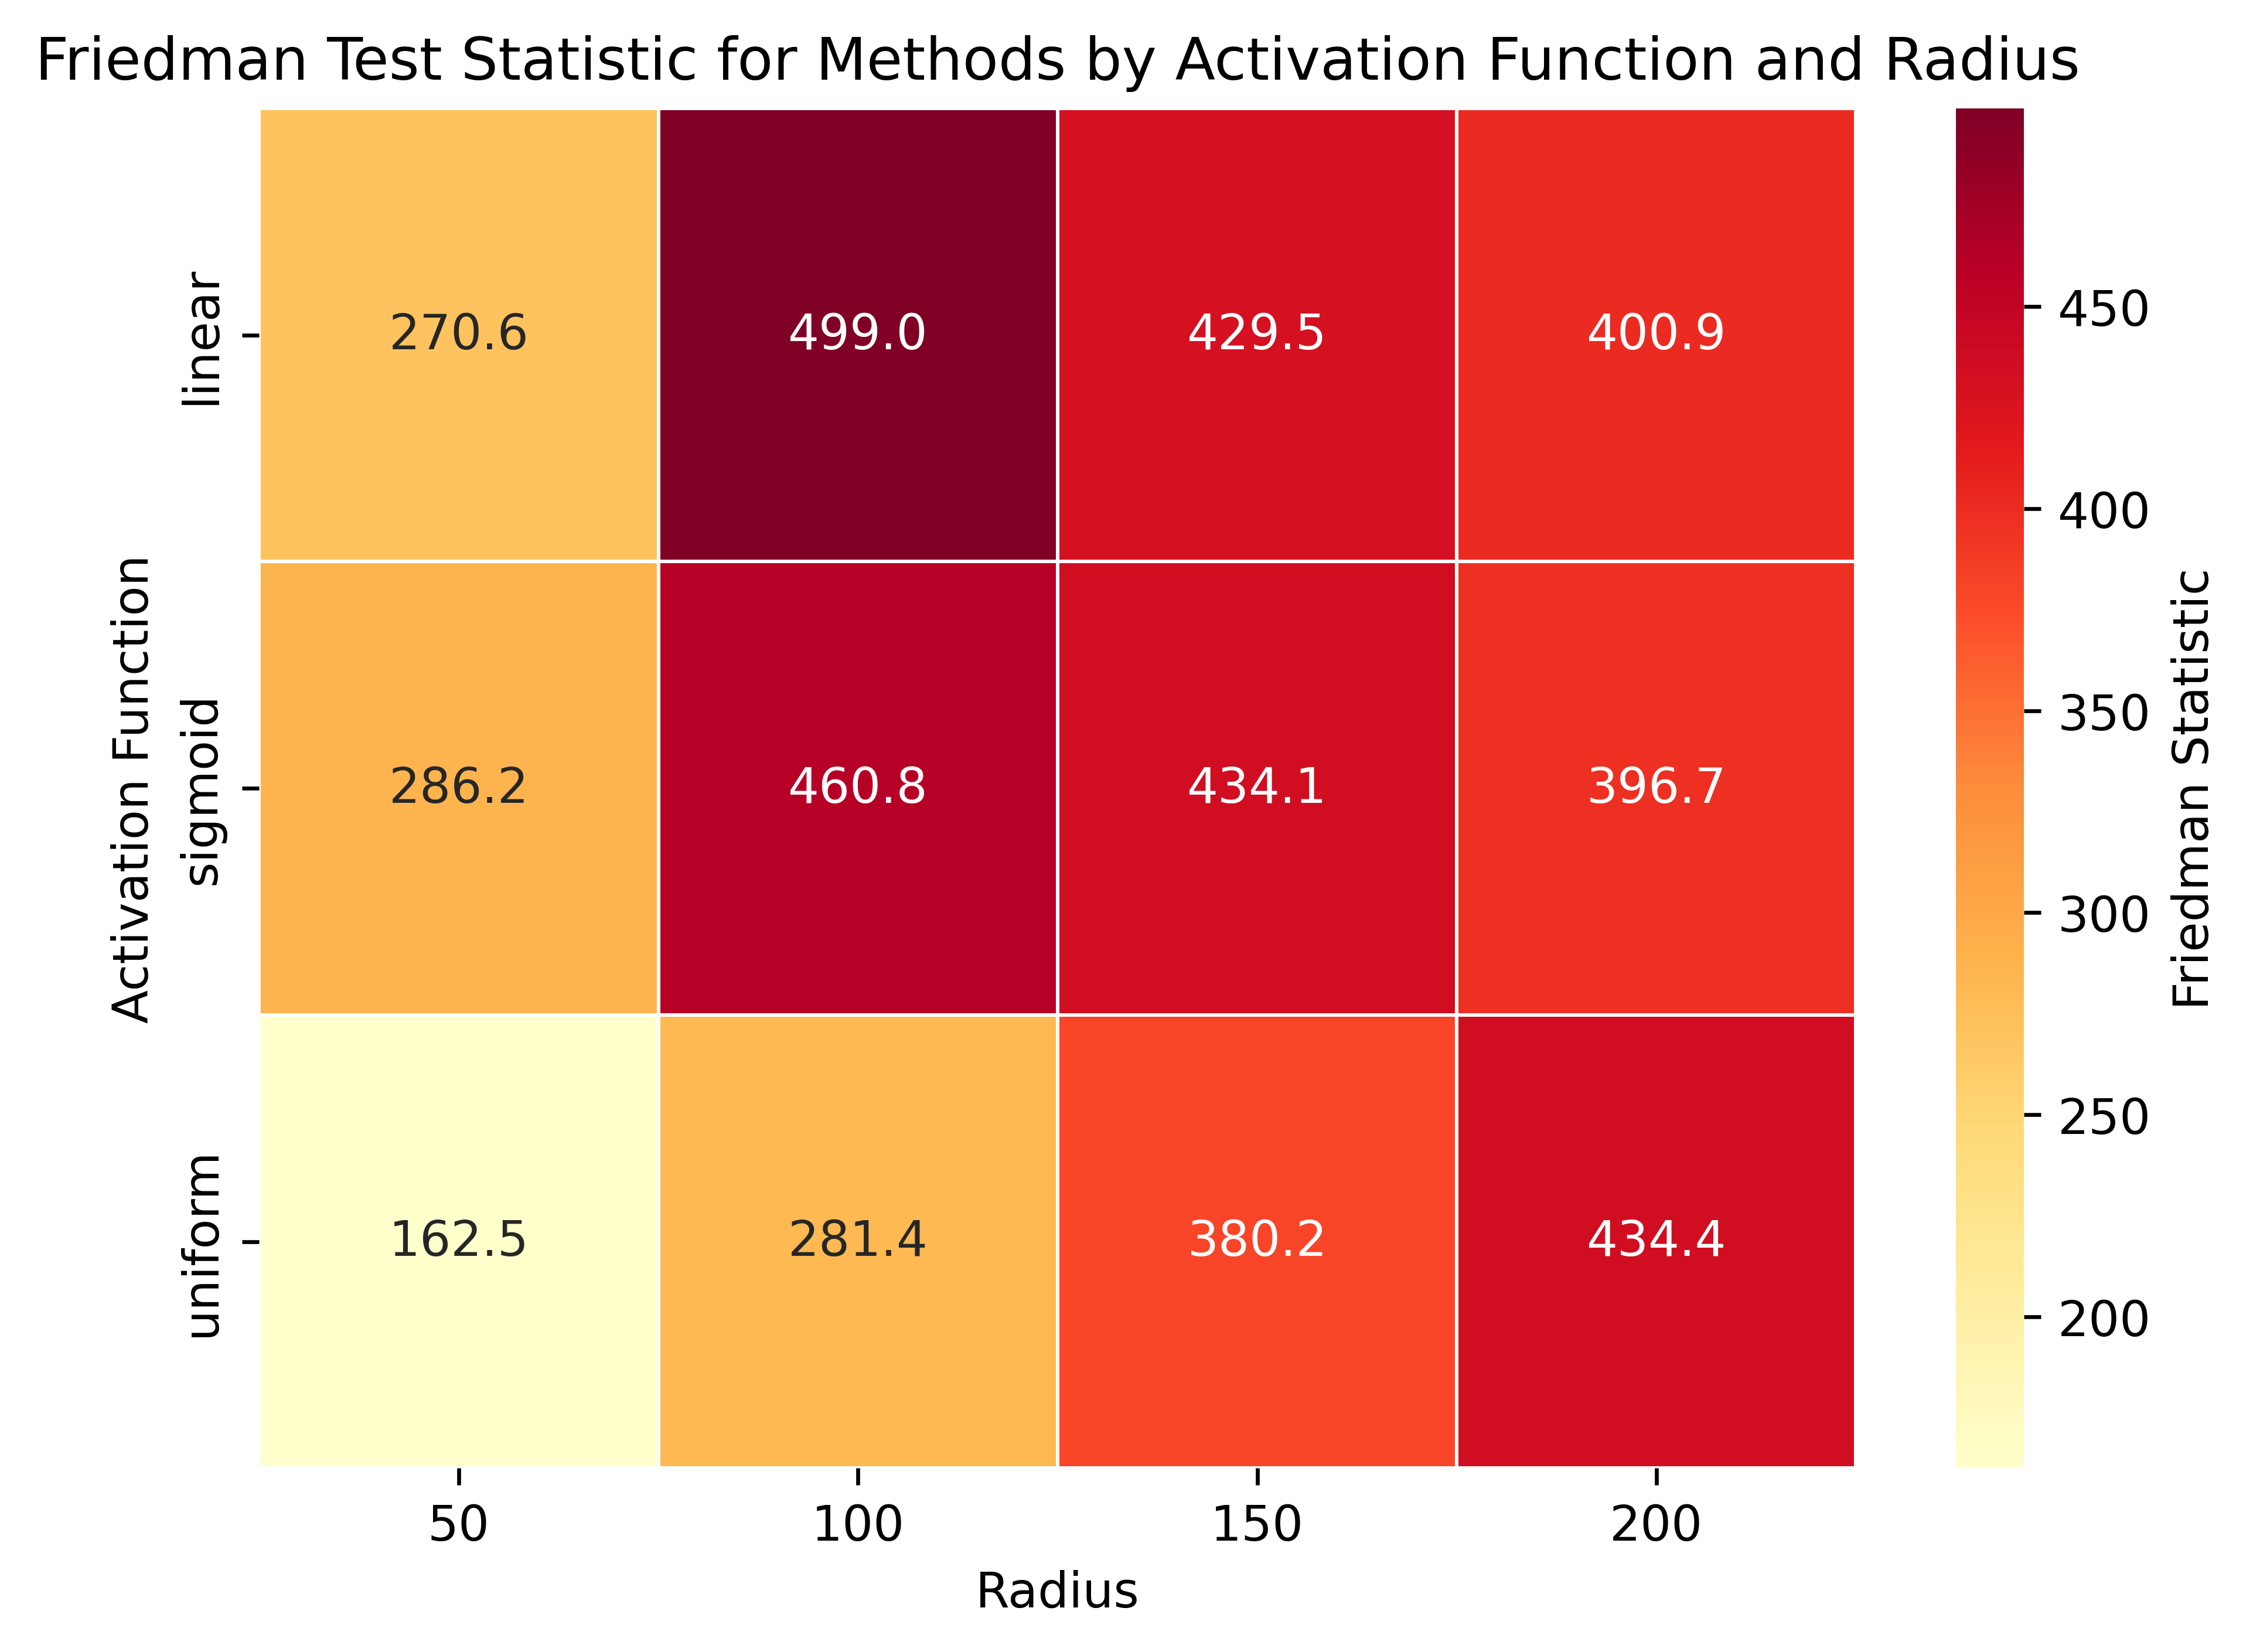

In [44]:
heatmap_data = friedman_results.pivot(
    index="activation_function",
    columns="radius",
    values="Friedman_statistic"
)

plt.figure(dpi=600)
sns.heatmap(
    heatmap_data,
    annot=True,        # show numbers
    fmt=".1f",         # one decimal
    cmap="YlOrRd",     # color map
    linewidths=0.5,
    cbar_kws={"label": "Friedman Statistic"}
)
plt.title("Friedman Test Statistic for Methods by Activation Function and Radius")
plt.xlabel("Radius")
plt.ylabel("Activation Function")
plt.tight_layout()
#plt.savefig("friedman_heatmap.png")
plt.show()

In [7]:
# Example: focus on one activation function, e.g. "sigmoid"
activation = "sigmoid"
df_act = df[df["activation_function"] == activation].copy()

results = {}

# Loop over radii for this activation function
for radius in sorted(df_act["radius"].unique()):
    df_subset = df_act[df_act["radius"] == radius].copy()
    
    # Number runs per radius to create a proper pivot table
    df_subset["run"] = df_subset.groupby(["method"]).cumcount()
    
    # Pivot table: rows = run, columns = method, values = best_score
    pivot_table = df_subset.pivot(
        index="run",
        columns="method",
        values="best_score"
    ).dropna()  # Only keep runs with all methods
    
    print(f"\n--- Activation: {activation}, Radius: {radius} ---")
    
    # Friedman test
    stat, p = friedmanchisquare(*[pivot_table[col] for col in pivot_table.columns])
    print(f"Friedman statistic = {stat:.4f}, p-value = {p:.4e}")
    
    # Post-hoc Nemenyi test
    posthoc = sp.posthoc_nemenyi_friedman(pivot_table)
    print("\nPost-hoc Nemenyi p-values:")
    print(posthoc)
    
    # Store results
    results[radius] = {
        "friedman_stat": stat,
        "p_value": p,
        "posthoc": posthoc
    }


--- Activation: sigmoid, Radius: 50 ---
Friedman statistic = 286.2054, p-value = 9.6176e-62

Post-hoc Nemenyi p-values:
              bruteforce  buildingwalk       dfs  hillclimb
bruteforce      1.000000           0.0  0.465200   0.099694
buildingwalk    0.000000           1.0  0.000000   0.000000
dfs             0.465200           0.0  1.000000   0.836353
hillclimb       0.099694           0.0  0.836353   1.000000

--- Activation: sigmoid, Radius: 100 ---
Friedman statistic = 460.7968, p-value = 1.4924e-99

Post-hoc Nemenyi p-values:
              bruteforce  buildingwalk       dfs  hillclimb
bruteforce      1.000000           0.0  0.014890   0.000045
buildingwalk    0.000000           1.0  0.000000   0.000000
dfs             0.014890           0.0  1.000000   0.445792
hillclimb       0.000045           0.0  0.445792   1.000000

--- Activation: sigmoid, Radius: 150 ---
Friedman statistic = 434.0635, p-value = 9.2473e-94

Post-hoc Nemenyi p-values:
                bruteforce  buildin

In [9]:
all_results = {}

for activation in df["activation_function"].unique():
    df_act = df[df["activation_function"] == activation].copy()
    results = {}
    for radius in sorted(df_act["radius"].unique()):
        df_subset = df_act[df_act["radius"] == radius].copy()
        df_subset["run"] = df_subset.groupby(["method"]).cumcount()
        pivot_table = df_subset.pivot(index="run", columns="method", values="best_score").dropna()
        
        stat, p = friedmanchisquare(*[pivot_table[col] for col in pivot_table.columns])
        posthoc = sp.posthoc_nemenyi_friedman(pivot_table)
        
        results[radius] = {"friedman_stat": stat, "p_value": p, "posthoc": posthoc}
    
    all_results[activation] = results
print(all_results)

{'sigmoid': {np.int64(50): {'friedman_stat': np.float64(286.2054429028821), 'p_value': np.float64(9.617590519439552e-62), 'posthoc':               bruteforce  buildingwalk       dfs  hillclimb
bruteforce      1.000000           0.0  0.465200   0.099694
buildingwalk    0.000000           1.0  0.000000   0.000000
dfs             0.465200           0.0  1.000000   0.836353
hillclimb       0.099694           0.0  0.836353   1.000000}, np.int64(100): {'friedman_stat': np.float64(460.7968146718154), 'p_value': np.float64(1.4923726703245973e-99), 'posthoc':               bruteforce  buildingwalk       dfs  hillclimb
bruteforce      1.000000           0.0  0.014890   0.000045
buildingwalk    0.000000           1.0  0.000000   0.000000
dfs             0.014890           0.0  1.000000   0.445792
hillclimb       0.000045           0.0  0.445792   1.000000}, np.int64(150): {'friedman_stat': np.float64(434.0635394456285), 'p_value': np.float64(9.247276087251272e-94), 'posthoc':                 brut

In [10]:
all_posthoc_rows = []

# Loop over all activation functions
for activation in df["activation_function"].unique():
    df_act = df[df["activation_function"] == activation].copy()
    
    # Loop over all radii
    for radius in sorted(df_act["radius"].unique()):
        df_subset = df_act[df_act["radius"] == radius].copy()
        
        # Number runs per method to align them
        df_subset["run"] = df_subset.groupby("method").cumcount()
        
        # Pivot: rows = run, columns = method, values = best_score
        pivot_table = df_subset.pivot(
            index="run",
            columns="method",
            values="best_score"
        ).dropna()
        
        # Skip if less than 2 methods
        if pivot_table.shape[1] < 2:
            continue
        
        # Friedman test
        stat, p = friedmanchisquare(*[pivot_table[col] for col in pivot_table.columns])
        
        # Post-hoc Nemenyi test
        posthoc = sp.posthoc_nemenyi_friedman(pivot_table)
        
        # Convert posthoc matrix to long format
        posthoc_long = posthoc.reset_index().melt(id_vars="index", var_name="method2", value_name="p_value")
        posthoc_long.rename(columns={"index": "method1"}, inplace=True)
        
        # Keep only upper triangle (avoid duplicates)
        posthoc_long = posthoc_long[posthoc_long["method1"] < posthoc_long["method2"]]
        
        # Add activation and radius info
        posthoc_long["activation_function"] = activation
        posthoc_long["radius"] = radius
        posthoc_long["friedman_stat"] = stat
        posthoc_long["friedman_p"] = p
        
        # Append to list
        all_posthoc_rows.append(posthoc_long)

# Combine all results into a single table
posthoc_table = pd.concat(all_posthoc_rows, ignore_index=True)

# Optional: reorder columns for readability
posthoc_table = posthoc_table[[
    "activation_function", "radius", "method1", "method2", "friedman_stat", "friedman_p", "p_value"
]]

# Display
print(posthoc_table)

   activation_function  radius       method1       method2  friedman_stat  \
0              sigmoid      50    bruteforce  buildingwalk     286.205443   
1              sigmoid      50    bruteforce           dfs     286.205443   
2              sigmoid      50  buildingwalk           dfs     286.205443   
3              sigmoid      50    bruteforce     hillclimb     286.205443   
4              sigmoid      50  buildingwalk     hillclimb     286.205443   
..                 ...     ...           ...           ...            ...   
67             uniform     200    bruteforce           dfs     434.405629   
68             uniform     200  buildingwalk           dfs     434.405629   
69             uniform     200    bruteforce     hillclimb     434.405629   
70             uniform     200  buildingwalk     hillclimb     434.405629   
71             uniform     200           dfs     hillclimb     434.405629   

      friedman_p       p_value  
0   9.617591e-62  0.000000e+00  
1   9.617

In [11]:
print(posthoc_table.to_latex(multirow=True, escape=False))

\begin{tabular}{llrllrrr}
\toprule
 & activation_function & radius & method1 & method2 & friedman_stat & friedman_p & p_value \\
\midrule
0 & sigmoid & 50 & bruteforce & buildingwalk & 286.205443 & 0.000000 & 0.000000 \\
1 & sigmoid & 50 & bruteforce & dfs & 286.205443 & 0.000000 & 0.465200 \\
2 & sigmoid & 50 & buildingwalk & dfs & 286.205443 & 0.000000 & 0.000000 \\
3 & sigmoid & 50 & bruteforce & hillclimb & 286.205443 & 0.000000 & 0.099694 \\
4 & sigmoid & 50 & buildingwalk & hillclimb & 286.205443 & 0.000000 & 0.000000 \\
5 & sigmoid & 50 & dfs & hillclimb & 286.205443 & 0.000000 & 0.836353 \\
6 & sigmoid & 100 & bruteforce & buildingwalk & 460.796815 & 0.000000 & 0.000000 \\
7 & sigmoid & 100 & bruteforce & dfs & 460.796815 & 0.000000 & 0.014890 \\
8 & sigmoid & 100 & buildingwalk & dfs & 460.796815 & 0.000000 & 0.000000 \\
9 & sigmoid & 100 & bruteforce & hillclimb & 460.796815 & 0.000000 & 0.000045 \\
10 & sigmoid & 100 & buildingwalk & hillclimb & 460.796815 & 0.000000 & 0.000

In [12]:
significant_rows = []

# Loop over all activation functions
for activation in df["activation_function"].unique():
    df_act = df[df["activation_function"] == activation].copy()
    
    # Loop over all radii
    for radius in sorted(df_act["radius"].unique()):
        df_subset = df_act[df_act["radius"] == radius].copy()
        
        # Number runs per method to align them
        df_subset["run"] = df_subset.groupby("method").cumcount()
        
        # Pivot: rows = run, columns = method, values = best_score
        pivot_table = df_subset.pivot(
            index="run",
            columns="method",
            values="best_score"
        ).dropna()
        
        if pivot_table.shape[1] < 2:
            continue
        
        # Friedman test
        stat, p = friedmanchisquare(*[pivot_table[col] for col in pivot_table.columns])
        
        # Nemenyi post-hoc
        posthoc = sp.posthoc_nemenyi_friedman(pivot_table)
        
        # Convert posthoc to long format
        posthoc_long = posthoc.reset_index().melt(id_vars="index", var_name="method2", value_name="p_value")
        posthoc_long.rename(columns={"index": "method1"}, inplace=True)
        
        # Keep only upper triangle
        posthoc_long = posthoc_long[posthoc_long["method1"] < posthoc_long["method2"]]
        
        # Add info
        posthoc_long["activation_function"] = activation
        posthoc_long["radius"] = radius
        posthoc_long["friedman_stat"] = stat
        posthoc_long["friedman_p"] = p
        
        # Keep only significant pairs
        significant_long = posthoc_long[posthoc_long["p_value"] < 0.05]
        
        # Append to list
        significant_rows.append(significant_long)

# Combine all results into one table
significant_table = pd.concat(significant_rows, ignore_index=True)

# Reorder columns for readability
significant_table = significant_table[[
    "activation_function", "radius", "method1", "method2",
    "friedman_stat", "friedman_p", "p_value"
]]

# Display
print(significant_table)

   activation_function  radius       method1       method2  friedman_stat  \
0              sigmoid      50    bruteforce  buildingwalk     286.205443   
1              sigmoid      50  buildingwalk           dfs     286.205443   
2              sigmoid      50  buildingwalk     hillclimb     286.205443   
3              sigmoid     100    bruteforce  buildingwalk     460.796815   
4              sigmoid     100    bruteforce           dfs     460.796815   
5              sigmoid     100  buildingwalk           dfs     460.796815   
6              sigmoid     100    bruteforce     hillclimb     460.796815   
7              sigmoid     100  buildingwalk     hillclimb     460.796815   
8              sigmoid     150    bruteforce  buildingwalk     434.063539   
9              sigmoid     150    bruteforce           dfs     434.063539   
10             sigmoid     150  buildingwalk           dfs     434.063539   
11             sigmoid     150    bruteforce     hillclimb     434.063539   

In [13]:
print(significant_table.to_latex(multirow=True, escape=False))

\begin{tabular}{llrllrrr}
\toprule
 & activation_function & radius & method1 & method2 & friedman_stat & friedman_p & p_value \\
\midrule
0 & sigmoid & 50 & bruteforce & buildingwalk & 286.205443 & 0.000000 & 0.000000 \\
1 & sigmoid & 50 & buildingwalk & dfs & 286.205443 & 0.000000 & 0.000000 \\
2 & sigmoid & 50 & buildingwalk & hillclimb & 286.205443 & 0.000000 & 0.000000 \\
3 & sigmoid & 100 & bruteforce & buildingwalk & 460.796815 & 0.000000 & 0.000000 \\
4 & sigmoid & 100 & bruteforce & dfs & 460.796815 & 0.000000 & 0.014890 \\
5 & sigmoid & 100 & buildingwalk & dfs & 460.796815 & 0.000000 & 0.000000 \\
6 & sigmoid & 100 & bruteforce & hillclimb & 460.796815 & 0.000000 & 0.000045 \\
7 & sigmoid & 100 & buildingwalk & hillclimb & 460.796815 & 0.000000 & 0.000000 \\
8 & sigmoid & 150 & bruteforce & buildingwalk & 434.063539 & 0.000000 & 0.000000 \\
9 & sigmoid & 150 & bruteforce & dfs & 434.063539 & 0.000000 & 0.000000 \\
10 & sigmoid & 150 & buildingwalk & dfs & 434.063539 & 0.00000

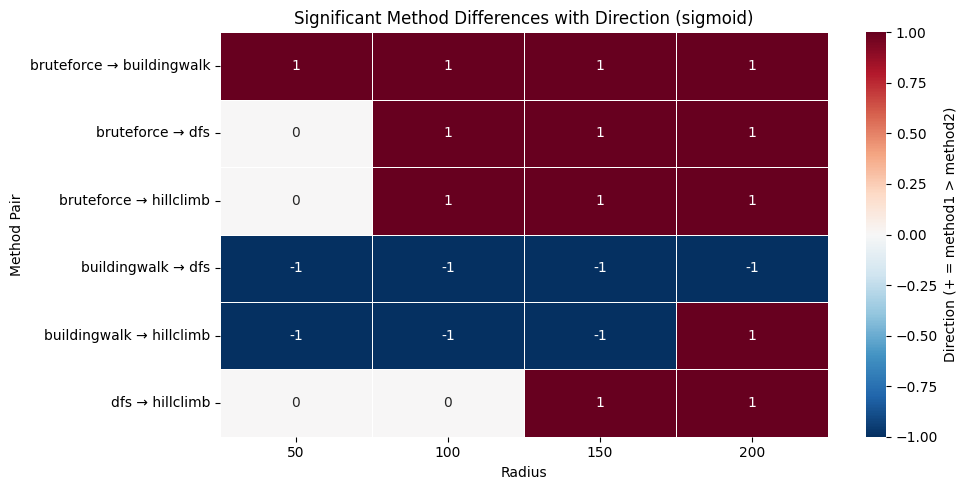

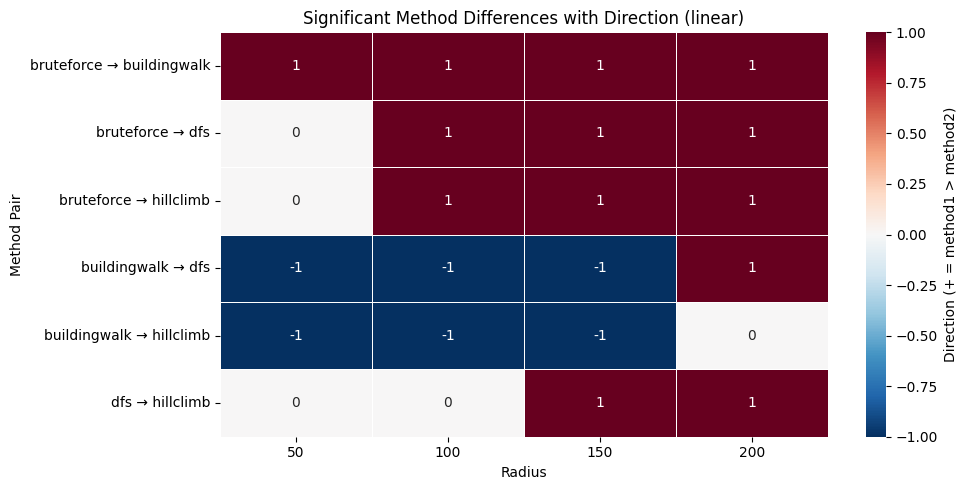

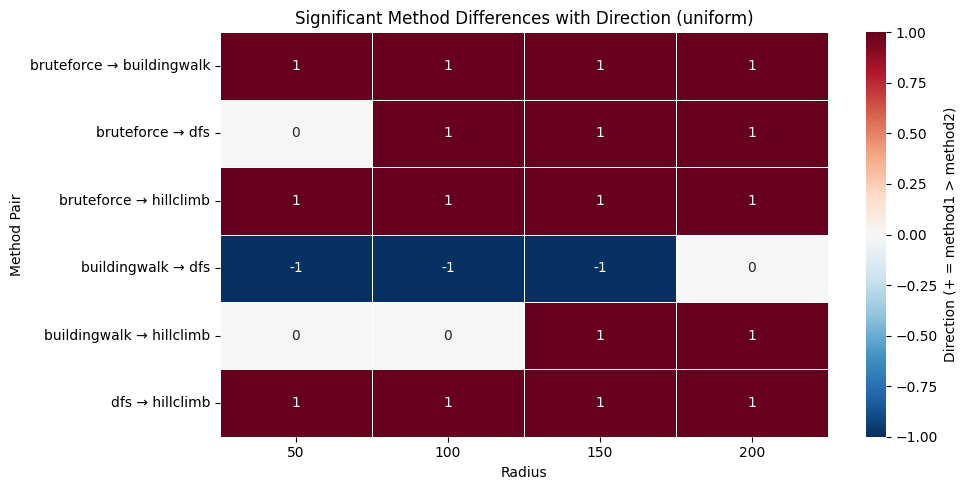

In [16]:
# Loop over activation functions
for activation in df["activation_function"].unique():
    df_act = significant_table[significant_table["activation_function"] == activation].copy()
    
    if df_act.empty:
        continue
    
    # Merge in mean scores to compute direction
    df_scores = df[df["activation_function"] == activation].groupby(
        ["radius", "method"]
    )["best_score"].mean().reset_index()
    
    # Add direction column for significant pairs
    df_act = df_act.merge(
        df_scores.rename(columns={"best_score": "mean_score1"}), 
        left_on=["radius", "method1"], right_on=["radius", "method"], 
        how="left"
    ).drop(columns=["method"])
    
    df_act = df_act.merge(
        df_scores.rename(columns={"best_score": "mean_score2"}), 
        left_on=["radius", "method2"], right_on=["radius", "method"], 
        how="left"
    ).drop(columns=["method"])
    
    # Compute direction: +1 if method1 > method2, -1 if method1 < method2
    df_act["direction"] = 0
    df_act.loc[df_act["mean_score1"] > df_act["mean_score2"], "direction"] = 1
    df_act.loc[df_act["mean_score1"] < df_act["mean_score2"], "direction"] = -1
    
    # Create method pair column
    df_act["method_pair"] = df_act["method1"] + " → " + df_act["method2"]
    
    # Pivot table for heatmap: rows = method_pair, columns = radius, values = direction
    pivot_table = pd.pivot_table(
        df_act, 
        index="method_pair", 
        columns="radius", 
        values="direction", 
        fill_value=0
    )
    
    # Sort rows
    pivot_table = pivot_table.sort_index()
    
    # Plot heatmap
    plt.figure(figsize=(10, len(pivot_table)*0.5 + 2))
    sns.heatmap(
        pivot_table, 
        annot=True, 
        cmap="RdBu_r",   # Red = method1 higher, Blue = method2 higher
        center=0,
        cbar_kws={"label": "Direction (+ = method1 > method2)"},
        linewidths=0.5,
        fmt=".0f"
    )
    plt.title(f"Significant Method Differences with Direction ({activation})")
    plt.ylabel("Method Pair")
    plt.xlabel("Radius")
    plt.tight_layout()
    plt.show()

In [17]:
friedman_rows = []
nemenyi_rows = []

# Loop over activation functions
for activation in df["activation_function"].unique():
    df_act = df[df["activation_function"] == activation].copy()
    
    # Loop over radii
    for radius in sorted(df_act["radius"].unique()):
        df_subset = df_act[df_act["radius"] == radius].copy()
        
        # Number runs per method to align them
        df_subset["run"] = df_subset.groupby("method").cumcount()
        
        # Pivot: rows = run, columns = method, values = best_score
        pivot_table = df_subset.pivot(
            index="run",
            columns="method",
            values="best_score"
        ).dropna()
        
        if pivot_table.shape[1] < 2:
            continue
        
        # --- Friedman ---
        stat, p = friedmanchisquare(*[pivot_table[col] for col in pivot_table.columns])
        friedman_rows.append({
            "activation_function": activation,
            "radius": radius,
            "friedman_stat": stat,
            "friedman_p": f"{p:.6e}"  # scientific notation
        })
        
        # --- Nemenyi ---
        posthoc = sp.posthoc_nemenyi_friedman(pivot_table)
        posthoc_long = posthoc.reset_index().melt(id_vars="index", var_name="method2", value_name="nemenyi_p")
        posthoc_long.rename(columns={"index": "method1"}, inplace=True)
        posthoc_long = posthoc_long[posthoc_long["method1"] < posthoc_long["method2"]]  # upper triangle
        
        posthoc_long["activation_function"] = activation
        posthoc_long["radius"] = radius
        # format p-values
        posthoc_long["nemenyi_p"] = posthoc_long["nemenyi_p"].apply(lambda x: f"{x:.6e}")
        
        nemenyi_rows.append(posthoc_long)

# Combine tables
friedman_table = pd.DataFrame(friedman_rows)
nemenyi_table = pd.concat(nemenyi_rows, ignore_index=True)

# Reorder Nemenyi columns
nemenyi_table = nemenyi_table[[
    "activation_function", "radius", "method1", "method2", "nemenyi_p"
]]

# Display
print("=== Friedman Table ===")
print(friedman_table)
print("\n=== Nemenyi Table ===")
print(nemenyi_table)

=== Friedman Table ===
   activation_function  radius  friedman_stat     friedman_p
0              sigmoid      50     286.205443   9.617591e-62
1              sigmoid     100     460.796815   1.492373e-99
2              sigmoid     150     434.063539   9.247276e-94
3              sigmoid     200     396.745989   1.121992e-85
4               linear      50     270.556619   2.339065e-58
5               linear     100     499.039518  7.705853e-108
6               linear     150     429.472620   9.133159e-93
7               linear     200     400.922385   1.397526e-86
8              uniform      50     162.485588   5.329654e-35
9              uniform     100     281.367713   1.071248e-60
10             uniform     150     380.179918   4.345625e-82
11             uniform     200     434.405629   7.796513e-94

=== Nemenyi Table ===
   activation_function  radius       method1       method2     nemenyi_p
0              sigmoid      50    bruteforce  buildingwalk  0.000000e+00
1              

In [18]:
friedman_results = []

# Loop over activation function + radius blocks
for (activation, radius), df_block in df.groupby(["activation_function", "radius"]):
    
    # Align repeated runs per method
    df_block = df_block.copy()
    df_block["run"] = df_block.groupby("method").cumcount()
    
    # Pivot so each column = method, each row = one repeated run
    pivot = df_block.pivot(
        index="run",
        columns="method",
        values="best_score"
    ).dropna()
    
    # Only test if we have at least 2 methods
    if pivot.shape[1] > 1:
        stat, p = friedmanchisquare(*[pivot[col] for col in pivot.columns])
        
        friedman_results.append({
            "activation_function": activation,
            "radius": radius,
            "friedman_statistic": stat,
            "p_value": p
        })

friedman_table = pd.DataFrame(friedman_results)

# Show full scientific notation
friedman_table["p_value"] = friedman_table["p_value"].apply(lambda x: f"{x:.6e}")

print(friedman_table)

   activation_function  radius  friedman_statistic        p_value
0               linear      50          270.556619   2.339065e-58
1               linear     100          499.039518  7.705853e-108
2               linear     150          429.472620   9.133159e-93
3               linear     200          400.922385   1.397526e-86
4              sigmoid      50          286.205443   9.617591e-62
5              sigmoid     100          460.796815   1.492373e-99
6              sigmoid     150          434.063539   9.247276e-94
7              sigmoid     200          396.745989   1.121992e-85
8              uniform      50          162.485588   5.329654e-35
9              uniform     100          281.367713   1.071248e-60
10             uniform     150          380.179918   4.345625e-82
11             uniform     200          434.405629   7.796513e-94
